In [2]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### 종목 선정 모델 개발     

선형모델에 대한 중요한 가정과 설명은 다음 절에서 추가로 설명드리겠으나,  수익률에 따라 단조 증가나 감소의 형태를 보이지 않는 피쳐(설명변수)는 변형을 해야 선형모형에서 더 유의미하게 사용될 수 있습니다.  주로 Binning (오름차순으로 정렬 후, 여러개 구간으로 분리) 을 통하여 이런 비선형적인 관계를 선형적으로 변경합니다.  우리는 앞서 수익율과 피쳐사이에 선형적인 관계를 가지지 않는 가설(예: 섹터의 평균 수익률 대비 종목 수익률)들 이 있었습니다. 이런 피처들에 대하여 Binning 없이 적합할 수 있는 모델이 일반화가법모형(Generalized Additive Model) 입니다. 또한 가설 검정에서는 5 영업일 동안의 최대 수익률을 예측변수로 이용했으나, 모델의 overfitting (과대적합) 문제를 최소화하기 위하여, 예측값을 이진값(0/1)으로 치환한 후, 로지스틱 일반화가법모형(Logistic Generalized Additive Model) 을 구현합니다. 로지스틱 회귀모형은 log(odds) = a0 + a1*x1 + a2*x2 … 으로 표현할 수 있는데요. 여기서 X 를 여러개의 spline 로 함수로 만든 후, 다시 합하여 X 와 Log(odds) 의  비선형적관계를 표현할 수 있도록 한 것이  Logistic GAM 입니다.  이 모델의 구현은 Statsmodels 에서 가능합니다만, pyGAM 패키지는 자동으로 하이퍼파라미터를 찾는 기능이 있어 편리합니다. GAM 을 선택한 다른 이유는 피처사이에 상호작용이 크지 않을 것이라는 가정이 있습니다. 무엇보다도 좋은 점은 모델이 왜 이 종목을 선택했는지에 대한 해석이 가능합니다. 향후, 모델의 예측력이 저하되는 경우 어떤 피처가 원인인지도 파악이 가능합니다. 

스코어가 높은 모든 종목을 매수하는 것이 아니라,  오늘의 종가 수익률과 주가를 고려하여 기본적인 필터링을 합니다. 종가 수익률은 높고, 최근 20일 대비 가격이 낮은 종목을 매수하면 리스크가 적은 것으로 판단됩니다.

이번절에서는 책에서 종목선정을 위해 사용할 GAM 모델을 개발하겠습니다. 아나콘다 프롬프트에서 conda install -c conda-forge pygam 로 설치를 해 줍니다. 관련 링크 https://anaconda.org/conda-forge/pygam

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 5% 익절은 다음과 같이 데이터로 표현할 수 있습니다. - 'max_close' 가 5% 이상일 때 1, 아니면 0. 파이썬 코드는 아래와 같습니다.
```python
np.where(feature_all['max_close']>= 1.05, 1, 0)
``` 
타겟 변수 - 'target' 값이 1 인 비율을 보니, 약 24% 입니다. 타겟변수의 비율이 너무 적으면 모델 트레이닝이 어렵습니다. 

In [19]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.3%


<br> 날짜와 종목은 모델의 입력피처가 아닙니다. 편의를 위해 제거하거나 인덱스로 처리합니다. 모델 트레이닝 용도로 10,000 개 샘플을 뽑아 예측모델을 만들고, 나머지 데이터는 테스트(혹은 백테스팅)를 하겠습니다.  

In [20]:
mdl_all = feature_all.set_index([feature_all.index,'code'])

train = mdl_all.sample(10000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]
print(len(train), len(test))

10000 320186


입력 피처의 갯수와 데이터타입을 확인합니다.

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, (Timestamp('2022-01-19 00:00:00'), '213420') to (Timestamp('2021-07-01 00:00:00'), '140860')
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sector              10000 non-null  object 
 1   return              10000 non-null  float64
 2   kosdaq_return       10000 non-null  float64
 3   price_z             10000 non-null  float64
 4   volume_z            10000 non-null  float64
 5   num_high/close      10000 non-null  float64
 6   num_long            10000 non-null  float64
 7   num_z>1.96          10000 non-null  float64
 8   num_win_market      10000 non-null  float64
 9   pct_win_market      10000 non-null  float64
 10  return over sector  10000 non-null  float64
 11  max_close           10000 non-null  float64
 12  mean_close          10000 non-null  float64
 13  min_close           10000 non-null  float64
 14  target              

<br> 각 변수별로 다른 'lambda' (Wiggliness Penalty Weight) 을 적용해서 grid Search 를 합니다. spline 수는 20 이 default 값입니다. spline 수는 고정하고 lambda의 최적 조합을 찾거나, lambda 를 고정하고, spline 수의 최적 조합을 찾는 것이 현실적이고, 두 하이퍼파라미터를 동시에 조합하여 grid Search 하는 것은 시간이 많이 걸립니다. 다양한 시도를 통하여 더 좋은 모델을 구현할 수 있겠으나, 이 책에서는 grid search 로 변수별 최적의 lambda 를 찾는 것으로 모델을 완성합니다. P value 가 크게 나타나는 입력변수는 제거하는 것이 좋겠습니다.

In [67]:
from pygam import LogisticGAM, s, f, te, l
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
X = train[feature_list]
y = train['target']
X_test = test[feature_list]
y_test = test['target']

# 하이퍼파라미터 설정 N 개의 변수면 (M x N) 개의 리스트로 생성함으로써 변수별로 다른 하이퍼파라미터 테스트 가능. 
# M 개만 1D 리스트를 만들면 동일한 lambda 른 모든 변수에 적용함.
lam_list = [np.logspace(0, 3, 2)]*8
   
gam = LogisticGAM(te(0, 1, n_splines=5) + s(1) + s(2) + s(3) + s(4) + te(4, 5, n_splines=5)).gridsearch(X.to_numpy(), y.to_numpy(), lam=lam_list) 

print(gam.summary())
print(gam.accuracy(X_test, y_test))

100% (256 of 256) |######################| Elapsed Time: 0:03:32 Time:  0:03:32


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     21.7127
Link Function:                        LogitLink Log Likelihood:                                 -5473.5193
Number of Samples:                        10000 AIC:                                            10990.4639
                                                AICc:                                           10990.5719
                                                UBRE:                                               3.1008
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0197
Feature Function                  Lam

In [68]:
for i, term in enumerate(gam.terms):
    print(i, term)

0 tensor_term
1 spline_term
2 spline_term
3 spline_term
4 spline_term
5 tensor_term
6 intercept_term


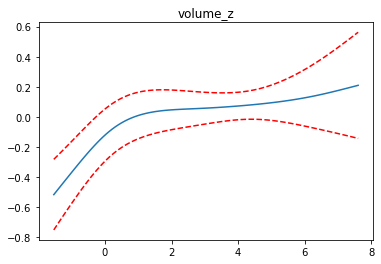

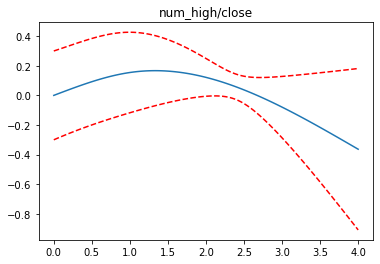

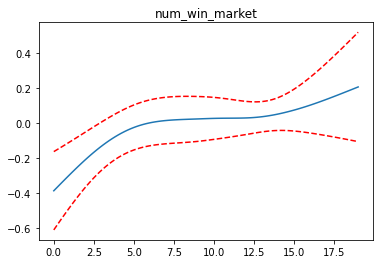

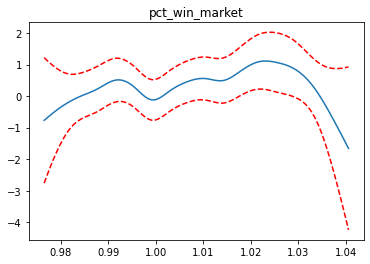

In [70]:
feature_list =  ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
for i, term in enumerate(gam.terms):
    
    if i>=1 and i<=4:

        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        plt.figure()
        plt.plot(XX[:, term.feature], pdep)
        plt.plot(XX[:, term.feature], confi, c='r', ls='--')
        plt.title(feature_list[i])
        plt.show()

<br> 완성된 모델을 pickle 로 binary 파일로 저장합니다.

In [71]:
import pickle
with open("gam.pkl", "wb") as file:
    pickle.dump(gam, file)    

In [6]:
with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

In [7]:
print(gam.get_params())
print(gam.coef_.shape)

{'max_iter': 100, 'tol': 0.0001, 'callbacks': [Deviance(), Diffs(), Accuracy()], 'verbose': False, 'terms': te(0, 1) + s(1) + s(2) + s(3) + s(4) + te(4, 5) + intercept, 'fit_intercept': True}
(131,)


In [8]:
for i in range(6):
    print(f'{i}: {gam._compute_p_value(i): 5.3f} {gam.generate_X_grid(term=i).shape}')

0:  0.000 (10000, 6)
1:  0.000 (100, 6)
2:  0.165 (100, 6)
3:  0.043 (100, 6)
4:  0.000 (100, 6)
5:  0.180 (10000, 6)


<br> 간단하게 십분위수 분석을 하고, 성능을 평가합니다. 안정적인 모델을 만들었습니다. 이론적으로는 마지막 Decile(제 10 십분위 수)에서 랜덤하게 종목을 골라 동일한 금액으로 매수를 한다면, 5 영업일이내 5% 익절할 확률이 37% 가 됩니다.  100% 만족스럽지는 않지만, 생성된 GAM 모델을 이용하여 종목 추천을 받도록 하겠습니다.

In [11]:
feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
X = train[feature_list]
y = train['target']
X_test = test[feature_list]
y_test = test['target']

yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

yhat_test = gam.predict_proba(X_test.to_numpy())
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index)

                 count  mean
yhat                        
(0.0607, 0.184]   1000 0.158
(0.184, 0.198]    1000 0.185
(0.198, 0.21]     1000 0.188
(0.21, 0.222]     1000 0.228
(0.222, 0.234]    1000 0.224
(0.234, 0.249]    1000 0.212
(0.249, 0.267]    1000 0.293
(0.267, 0.292]    1000 0.266
(0.292, 0.327]    1000 0.326
(0.327, 0.655]    1000 0.384
                 count  mean
yhat                        
(0.0342, 0.184]  32019 0.154
(0.184, 0.198]   32019 0.182
(0.198, 0.209]   32018 0.193
(0.209, 0.221]   32019 0.202
(0.221, 0.234]   32018 0.223
(0.234, 0.249]   32019 0.238
(0.249, 0.268]   32018 0.258
(0.268, 0.292]   32019 0.284
(0.292, 0.327]   32018 0.319
(0.327, 0.783]   32019 0.372


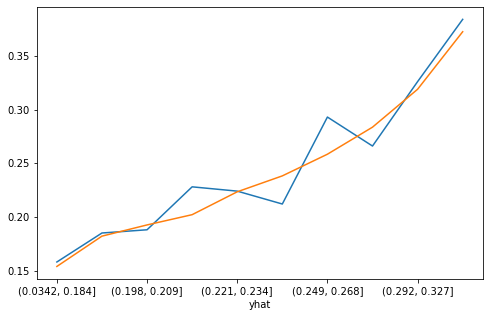

In [12]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot(figsize=(8,5))

perf(y, yhat)
perf(y_test, yhat_test)

### Basic Filtering
단순히 스코어가 높다고 무조건 매수했다가 큰 낙폭으로 손해를 볼 수도 있기 때문에 기본적인 필터링이 필요합니다. 오늘 종가 수익률과 가격 변동성으로 기본적인 필터를 만들어 보겠습니다.

In [13]:
test['yhat'] = yhat_test
test['yhat_rank'] = pd.qcut(test['yhat'], q=10)
test.groupby('yhat_rank')['target'].mean()

yhat_rank
(0.0342, 0.184]   0.154
(0.184, 0.198]    0.182
(0.198, 0.209]    0.193
(0.209, 0.221]    0.202
(0.221, 0.234]    0.223
(0.234, 0.249]    0.238
(0.249, 0.268]    0.258
(0.268, 0.292]    0.284
(0.292, 0.327]    0.319
(0.327, 0.783]    0.372
Name: target, dtype: float64

<br> 종목선정은 상위 스코어 구간에서 할 것이므로 상위 구간에서만 보겠습니다. 

In [15]:
tops = test[test['yhat'] > 0.3].copy()

tops['return_rank']  = pd.qcut(tops['return'], q=3) # 종가 수익률
tops['price_rank']  = pd.qcut(tops['price_z'], q=3) # 가격 변동성
tops.groupby(['return_rank','price_rank'])['target'].mean().unstack()

price_rank,"(-4.36, -1.262]","(-1.262, 0.928]","(0.928, 4.359]"
return_rank,,,
"(0.325, 0.973]",0.410,0.348,0.397
"(0.973, 1.008]",0.287,0.311,0.335
"(1.008, 1.3]",0.428,0.349,0.356


<br> 참고로 groupby 로 데이터를 요약하는 방법은 직관적이나, 각 행과 열의 총계는 보여주지 않는다는 단점이 있습니다. 총계가 보고 싶을 때는 pivot_table 에서 'margins=True' 를 인수로 넣어주면 총계를 볼 수 있습니다.

In [16]:
pd.pivot_table(data = tops, index = 'return_rank', columns = 'price_rank', values = 'target', aggfunc='mean', margins=True)

price_rank,"(-4.36, -1.262]","(-1.262, 0.928]","(0.928, 4.359]",All
return_rank,,,,
"(0.325, 0.973]",0.410,0.348,0.397,0.388
"(0.973, 1.008]",0.287,0.311,0.335,0.308
"(1.008, 1.3]",0.428,0.349,0.356,0.361
All,0.367,0.334,0.357,0.352


In [17]:
pd.pivot_table(data = tops, index = 'return_rank', columns = 'price_rank', values = 'min_close', aggfunc='mean', margins=True)

price_rank,"(-4.36, -1.262]","(-1.262, 0.928]","(0.928, 4.359]",All
return_rank,,,,
"(0.325, 0.973]",0.967,0.952,0.950,0.960
"(0.973, 1.008]",0.966,0.960,0.951,0.960
"(1.008, 1.3]",0.970,0.955,0.950,0.953
All,0.967,0.956,0.950,0.958


<br> 위 결과를 종합하면 종가 수익률은 높고, 최근 20일 대비 가격이 낮은 종목을 매수하면 리스크가 적을 것으로 판단됩니다.

In [18]:
tops['return_rank']  = pd.qcut(tops['return'], q=3, labels=range(3)) # 종가 수익률
tops['price_rank']  = pd.qcut(tops['price_z'], q=3, labels=range(3)) # 가격 변동성
tops[ (tops['return_rank']==2) & (tops['price_rank']==0)][['return_rank','price_rank']]


,,return_rank,price_rank
date,code,,
2021-07-05,037440,2,0
2021-07-09,037440,2,0
2021-08-23,037440,2,0
2021-10-07,010240,2,0
2021-12-01,010240,2,0
...,...,...,...
2021-10-21,211270,2,0
2021-12-01,054620,2,0
2022-01-12,054620,2,0
